In [34]:
import pandas as pd

In [35]:
df = pd.read_csv('Dataset/sp500.csv')

In [36]:
df.shape

(24465, 7)

In [37]:
df.index

RangeIndex(start=0, stop=24465, step=1)

<Axes: >

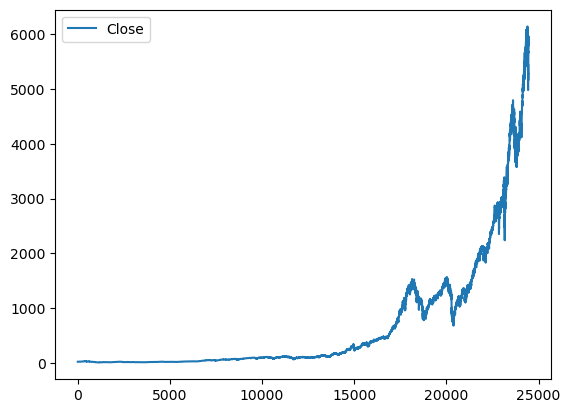

In [38]:
df.plot.line(y="Close", use_index=True)

In [39]:
del df['Dividends']
del df['Stock Splits']

In [40]:
df["Tomorrow"] = df['Close'].shift(-1)

In [41]:
df["Target"] = (df['Tomorrow'] > df['Close']).astype(int)

In [42]:
df.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
0,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
2,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
3,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
4,17.660000,17.660000,17.660000,17.660000,0,17.500000,0


In [43]:
df = df.loc["1990-1-1":].copy()

In [44]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [45]:
train = df.iloc[:-100]
test = df.iloc[-100:]

In [46]:
predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [47]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [48]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
preds = pd.Series(preds, index=test.index)

In [50]:
precision_score(test['Target'], preds)

0.5769230769230769

In [51]:
combined = pd.concat([test['Target'], preds],axis=1)

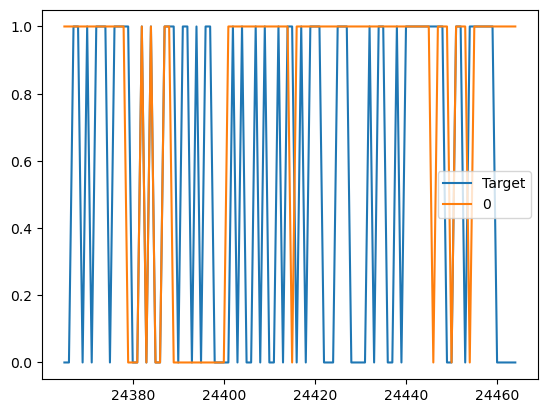

In [52]:
combined.plot();

In [53]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test['Target'], preds],axis=1)
    return combined

In [54]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = df.iloc[:i].copy()
        test = df.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [55]:
predictions = backtest(df, model, predictors)

In [56]:
predictions['Predictions'].value_counts()

Predictions
0    1389
1     676
Name: count, dtype: int64

In [57]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5295857988165681

In [58]:
predictions['Target'].value_counts() / predictions.shape[0]

Target
1    0.546731
0    0.453269
Name: count, dtype: float64

In [59]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [60]:
if df is not None:
    df = df.dropna()
else:
    print("DataFrame is None. Please check the data loading step.")

In [62]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [63]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds>= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test['Target'], preds],axis=1)
    return combined

In [64]:
predictions = backtest(df, model, new_predictors)

In [65]:
predictions['Predictions'].value_counts()

Predictions
0.0    924
1.0    140
Name: count, dtype: int64

In [66]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5428571428571428